<a href="https://colab.research.google.com/github/Colonna17/Collision_Avoidance-Sapienza_Vision_and_Perception/blob/main/notebooks/CCD_Classification_flow%26lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone --recurse-submodules https://github.com/Colonna17/Collision_Avoidance-Sapienza_Vision_and_Perception.git

%cd Collision_Avoidance-Sapienza_Vision_and_Perception
!./setup.sh 
# %pip install -qr external/yolov5/requirements.txt 
# %pip install -qr requirements.txt #install dependencies

Cloning into 'Collision_Avoidance-Sapienza_Vision_and_Perception'...
remote: Enumerating objects: 364, done.
remote: Counting objects: 100% (200/200), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 364 (delta 81), reused 135 (delta 32), pack-reused 164
Receiving objects: 100% (364/364), 294.30 MiB | 42.72 MiB/s, done.
Resolving deltas: 100% (127/127), done.
Submodule 'Yolov5_StrongSORT_OSNet' (https://github.com/mikel-brostrom/Yolov5_StrongSORT_OSNet.git) registered for path 'external/Yolov5_StrongSORT_OSNet'
Submodule 'yolov5' (https://github.com/ultralytics/yolov5.git) registered for path 'external/yolov5'
Cloning into '/content/Collision_Avoidance-Sapienza_Vision_and_Perception/external/Yolov5_StrongSORT_OSNet'...
remote: Enumerating objects: 4222, done.        
remote: Counting objects: 100% (550/550), done.        
remote: Compressing objects: 100% (248/248), done.        
remote: Total 4222 (delta 333), reused 477 (delta 283), pack-reused 3672        
Rece

In [6]:
!pwd

/content/Collision_Avoidance-Sapienza_Vision_and_Perception


In [7]:
import sys
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader,random_split
import torchvision
import torchvision.transforms as transforms

import os, cv2
import numpy as np
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt

from src.utils import numpy_brg_to_rgb, custom_from_numpy
sys.path.append('external/yolov5')
from external.yolov5.utils.dataloaders import LoadImages

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu') # ToDo: just for the moment. risolvere problema classificatore
device

device(type='cpu')

In [8]:
!nvidia-smi

Sat Jan 21 20:08:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Create the dataset 

In [9]:
# %cd /content/drive/MyDrive/Vision and Perception Project/Car Crash Dataset
data_dir = '/content/drive/MyDrive/Vision and Perception Project/Car Crash Dataset/videos'

# Cosa cambia?
# test_video_dir = data_dir + "/Crash-1500/"
test_video_dir = data_dir + '/Dataset/'
# test_annotation_file = data_dir + "/Crash-1500.txt"
test_annotation_file = data_dir + '/Dataset_annotations.txt'

In [10]:
!ls /content/drive/MyDrive/Vision\ and\ Perception\ Project/Car\ Crash\ Dataset/videos # data_dir

Crash-1500	Dataset			 Normal-50.txt		Test-Crash
Crash-1500.txt	Dataset_annotations.txt  Normal.zip
Crash-1500.zip	Normal-3000		 test_annontations.txt


In [11]:
# videos_directory = test_video_dir
# videos_paths = [ videos_directory + video_name for video_name in os.listdir(videos_directory) ]
# videos_paths

In [12]:
class CCDVideos(Dataset):
    def __init__(self, videos_directory, annotations_path):
        super().__init__()
        self.videos_paths = [ videos_directory + video_name for video_name in os.listdir(videos_directory) ]
        self.videos_paths.sort()
        self.annotations = self.read_annotations_file(annotations_path)

    def __getitem__(self, idx):
        video_frames = self.videos_paths[idx] # self.get_video_frames(self.videos_paths[idx])
        video_annotations = self.annotations[idx]
        return {'frames': video_frames, 'annotations': video_annotations}

    def __len__(self):
        return len(self.videos_paths)

    def read_annotations_file(self, annotations_path):
        assert os.path.exists(annotations_path), "Annotation file does not exist!" + annotations_path
        result = []
        with open(annotations_path, 'r') as f:
            for line in f.readlines():
                items = {}
                items['vid'] = line.strip().split(',[')[0]
                labels = line.strip().split(',[')[1].split('],')[0]
                items['labels'] = [int(val) for val in labels.split(',')]
                others = line.strip().split(',[')[1].split('],')[1].split(',')
                items['startframe'], items['vid_ytb'], items['lighting'], items['weather'], items['ego_involve'] = others
                result.append(items)
        f.close()
        return result
    
    @staticmethod
    def get_video_frames(video_file, topN=50):
        # get the video data
        cap = cv2.VideoCapture(video_file)
        ret, frame = cap.read() # Cos'è ret?
        
        video_data = []
        while (ret):
            video_data.append(numpy_brg_to_rgb(frame))
            ret, frame = cap.read()
        
        # Necessario?
        assert len(video_data) >= topN 
        video_data = video_data[:topN]
        
        return video_data

In [13]:
ccd_dataset = CCDVideos(test_video_dir, test_annotation_file)
# loader = DataLoader(ccd_dataset, batch_size=1) #, num_workers=0)

train_set, validation_set, test_set = random_split(ccd_dataset,[0.8, 0.1, 0.1],
                                                   generator=torch.Generator().manual_seed(38))
train_loader = DataLoader(train_set, batch_size=1) #, num_workers=0)
validation_loader = DataLoader(validation_set, batch_size=1) #, num_workers=0)
test_loader = DataLoader(test_set, batch_size=1) #, num_workers=0)

In [14]:
video_test = train_set[0]
frames_test = CCDVideos.get_video_frames(video_test['frames'])
frame0_nr = 0
frame1_nr = 10

Annotation:  0


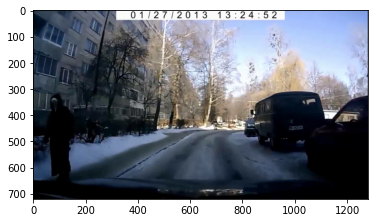

In [15]:
img0_test = frames_test[frame0_nr]
plt.imshow(img0_test)
print('Annotation: ', video_test['annotations']['labels'][frame0_nr])

Annotation:  0


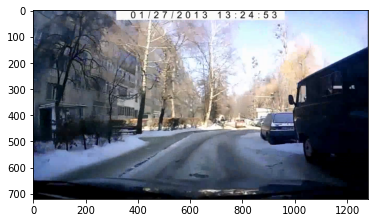

In [16]:
img1_test = frames_test[frame1_nr]
plt.imshow(img1_test)
print('Annotation: ', video_test['annotations']['labels'][frame1_nr])

# Optical Flow test (Just for fun)

In [17]:
from torchvision.utils import flow_to_image
import torchvision.transforms.functional as F

from src.opticalFlowEstimator import OpticalFlowEstimator

In [18]:
optical = OpticalFlowEstimator(device)
optical.eval()
print('')

Downloading: "https://download.pytorch.org/models/raft_small_C_T_V2-01064c6d.pth" to /root/.cache/torch/hub/checkpoints/raft_small_C_T_V2-01064c6d.pth


Frame size:  torch.Size([3, 720, 1280])
Flow size:  torch.Size([3, 720, 1280]) 



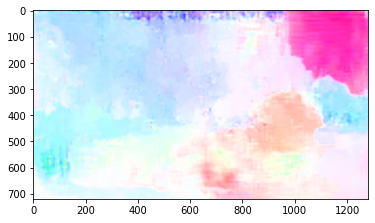

In [19]:
frame0 = torch.permute(custom_from_numpy(img0_test, device), (2,0,1)).unsqueeze(0)
frame1 = torch.permute(custom_from_numpy(img1_test, device), (2,0,1)).unsqueeze(0)

test_flow = optical(frame0, frame1)[-1]

test_flow = flow_to_image(test_flow).squeeze(0)
plt.imshow(F.to_pil_image(test_flow.to("cpu")))

print('Frame size: ', frame0.squeeze(0).shape)
print('Flow size: ', test_flow.shape, '\n')

# Hyperparameters

In [20]:
class HParams():
    # Model parameters
    img_size = (720, 1280, 3)
    lstm_hidden_dim = 32
    collision_threshold = 0.5
    
    # Training parameters
    lr = 1e-4
    num_epochs = 5

params = HParams()

# Model loading

In [21]:
# from src.classifier import Classifier
from src.build import build
from src.utils import DEFAULT_OPTIONS

options = DEFAULT_OPTIONS

/content/Collision_Avoidance-Sapienza_Vision_and_Perception/external/Yolov5_StrongSORT_OSNet/strong_sort/deep/reid/torchreid/metrics/rank.py:11: UserWarning: Cython evaluation (very fast so highly recommended) is unavailable, now use python evaluation.
  warnings.warn(


In [22]:
yolo, tracker, classifier = build(device, options)

INFO:yolov5:Fusing layers... 
Fusing layers... 
Fusing layers... 
Fusing layers... 
INFO:yolov5:Model summary: 267 layers, 46135203 parameters, 0 gradients, 107.7 GFLOPs
Model summary: 267 layers, 46135203 parameters, 0 gradients, 107.7 GFLOPs
Model summary: 267 layers, 46135203 parameters, 0 gradients, 107.7 GFLOPs
Model summary: 267 layers, 46135203 parameters, 0 gradients, 107.7 GFLOPs


Successfully loaded pretrained weights from "weights/osnet_x0_25_msmt17.pt"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']


# Classifier Training


In [23]:
optim = torch.optim.Adam(classifier.parameters(), lr=params.lr)

In [24]:
def train(model, optimizer, train_dataset, valid_dataset, device, options, yolo, tracker):
    torch.cuda.empty_cache()
    train_history = []
    valid_history = []
    yolo_scaled_img_size = (options['yolo_img_height'], options['yolo_img_width'])

    for epoch in range(params.num_epochs):
        print('Epoch {:03d}:'.format(epoch + 1))

        epoch_loss = 0.0
        model.train() 

        for step, video in enumerate(train_dataset):
            print('\tVideo nr: ', step)
            frames_path = video['frames']
            labels = torch.FloatTensor(video['annotations']['labels']).to(device)
            optimizer.zero_grad()
            
            frames = LoadImages(frames_path, img_size=yolo_scaled_img_size, stride=yolo.model.stride, auto=yolo.model.pt)
            
            predictions = []
            curr_frame, prev_frame = None, None
            h = None
            for frame_idx, (path, img_scaled, img, vid_cap, s) in enumerate(frames):
                curr_frame = img.copy()
                curr_frame_scaled = custom_from_numpy(img_scaled, device).unsqueeze(0)

                yolo_detections = yolo.detect(curr_frame_scaled)
                tracking_output = tracker.track(curr_frame, prev_frame, yolo_detections, curr_frame_scaled.shape[2:])
                
                if(frame_idx > 0): pred, h = classifier(curr_frame, prev_frame, tracking_output, h)
                else: pred, h = -1, None

                predictions.append(pred) #torch.cat((predictions, pred))
                prev_frame = curr_frame
            torch.FloatTensor(predictions).to(device)
            predictions = torch.FloatTensor(predictions).to(device) # predictions.squeeze()
            print(predictions)
            return
            # predictions = predictions.view(-1, predictions.shape[-1])
            # labels = labels.view(-1)

            sample_loss = model.loss(predictions, labels)
            sample_loss.backward()
            optimizer.step()

            epoch_loss += sample_loss.tolist()

        avg_epoch_loss = epoch_loss / len(train_dataset)
        train_history.append(avg_epoch_loss)
        print('\tTrain loss = {:0.4f}'.format(avg_epoch_loss))

        # avg_valid_loss = evaluate(model, valid_dataset)
        # valid_history.append(avg_valid_loss)
        # print('\tValid loss = {:0.4f}'.format(avg_valid_loss))
        # if early_stopping:
        #     stop = epoch > 0 and valid_history[-1] > valid_history[-2]
        #     if stop:
        #         if patience <= 0:
        #             if(verbose): print('\tEarly stop.')
        #             break
        #         else:
        #             if(verbose): print('\tPatience.')
        #             patience -= 1

    return {'train_history': train_history, 'valid_history': valid_history}

In [25]:
# def evaluate(model, validation_dataset):
#     return

In [ ]:
logs = train(classifier, optim, train_set, validation_set, device, options, yolo, tracker)

Epoch 001:
	Video nr:  0


In [ ]:
classifier.eval()
optim.zero_grad()
torch.cuda.empty_cache()

In [ ]:
def plot_training_logs(logs, title, out_img_name):
    plt.figure(figsize=(15,10))

    plt.plot(list(range(len(logs['train_history']))), logs['train_history'], label='Train loss')
    # plt.plot(list(range(len(logs['valid_history']))), logs['valid_history'], label='Test loss')
    
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc="upper right")
    plt.savefig(out_img_name)
    plt.show()

In [ ]:
logs

In [ ]:
plot_training_logs(logs, 'Train vs Test loss', 'loss_plot.png')

# Original Model [Da togliere?]

In [ ]:
# Original ConvLSTM cell as proposed by Shi et al.
# Adapted from https://github.com/ndrplz/ConvLSTM_pytorch

class ConvLSTMCell(torch.nn.Module):

    def __init__(self, in_channels, out_channels,  kernel_size, padding, activation, frame_size):
        """
        Initialize ConvLSTM cell.
        Parameters
        ----------
        in_channels: int
            Number of channels of input tensor.
        out_channels: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        """

        # super(ConvLSTMCell, self).__init__()  # Perchè?
        super().__init__()  

        if activation == "tanh":
            self.activation = torch.tanh 
        elif activation == "relu":
            self.activation = torch.relu
        
        self.conv = nn.Conv2d(in_channels = in_channels + out_channels, 
                              out_channels = 4 * out_channels, 
                              kernel_size = kernel_size, 
                              padding = padding)           

        # Initialize weights for Hadamard Products
        self.W_ci = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        self.W_co = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        self.W_cf = nn.Parameter(torch.Tensor(out_channels, *frame_size))

    def forward(self, X, H_prev, C_prev):
        """
        The following are all 3D tensors: first dimension is n° of channels/filters
        while second and third are Height and Width of a frame.
        i: input gate
        f: forget gate
        o: output gate
        C: cell state
        H: hidden state
        X: inputs
        W: weights matrices. They are a learnable set of kernels.
        """

        conv_output = self.conv(torch.cat([X, H_prev], dim=1))

        i_conv, f_conv, C_conv, o_conv = torch.chunk(conv_output, chunks=4, dim=1)

        input_gate = torch.sigmoid(i_conv + self.W_ci * C_prev )
        forget_gate = torch.sigmoid(f_conv + self.W_cf * C_prev )

        # Current Cell output
        C = forget_gate*C_prev + input_gate * self.activation(C_conv)

        output_gate = torch.sigmoid(o_conv + self.W_co * C )

        # Current Hidden State
        H = output_gate * self.activation(C)

        return H, C

In [ ]:
# Original ConvLSTM cell as proposed by Shi et al.
# Adapted from https://github.com/ndrplz/ConvLSTM_pytorch

class ConvLSTM(nn.Module): 
    """
    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.
    Input:
       X: A tensor of size (B =batch_size, T =num_channels, C =seq_len, H = height, W = width)
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, in_channels, out_channels, kernel_size, padding, activation, frame_size):
        # super(ConvLSTM, self).__init__()
        super().__init__()        

        self.out_channels = out_channels

        # We will unroll this over time steps. Remember that convLSTMcell returns
        # H hidden state and C cell
        self.convLSTMcell = ConvLSTMCell(in_channels, out_channels, kernel_size, padding, activation, frame_size)

    
    # X is a frame sequence of size (B, T, C, H, W) with (B = batch_size, T = num_channels, C = seq_len, H = height, W = width)
    def forward(self, X):
        # Get the dimensions
        batch_size, _, seq_len, height, width = X.size() # what is the ignored parameter

        # Initialize output
        output = torch.zeros(batch_size, self.out_channels, seq_len, 
        height, width, device=device)
        
        # Initialize Hidden State
        H = torch.zeros(batch_size, self.out_channels, 
        height, width, device=device)

        # Initialize Cell Input
        C = torch.zeros(batch_size,self.out_channels, 
        height, width, device=device)

        # Unroll over time steps
        for time_step in range(seq_len):

            H, C = self.convLSTMcell(X[:,:,time_step], H, C)

            output[:,:,time_step] = H

        return output

In [ ]:

class Seq2Seq(nn.Module):

    def __init__(self, num_channels, num_kernels, kernel_size, padding, activation, frame_size, num_layers):
        super(Seq2Seq, self).__init__()

        self.sequential = nn.Sequential()

        # Add First layer (Different in_channels than the rest)
        self.sequential.add_module(
            "convlstm", ConvLSTM(
                in_channels=num_channels, out_channels=num_kernels,
                kernel_size=kernel_size, padding=padding, 
                activation=activation, frame_size=frame_size)
        )

        # self.sequential.add_module(
        #     "batchnorm", nn.BatchNorm3d(num_features=num_kernels)
        # ) 

        # Add Convolutional Layer to predict output frame
        self.conv = nn.Conv2d(
            in_channels=num_kernels, out_channels=num_channels,
            kernel_size=kernel_size, padding=padding)

    def forward(self, X):

        # Forward propagation through all the layers
        output = self.sequential(X)

        # Return only the last output frame
        output = self.conv(output[:,:,-1])
        outpu = nn.Sigmoid()(output)
        
        return output

# Roba a caso [Da togliere?]

In [ ]:
# !pip install wandb
# import wandb
# wandb.init()

In [ ]:
# import nvidia_smi

# nvidia_smi.nvmlInit()

# deviceCount = nvidia_smi.nvmlDeviceGetCount()
# for i in range(deviceCount):
#     handle = nvidia_smi.nvmlDeviceGetHandleByIndex(i)
#     info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
#     print("Device {}: {}, Memory : ({:.2f}% free): {}(total), {} (free), {} (used)".format(i, nvidia_smi.nvmlDeviceGetName(handle), 100*info.free/info.total, info.total, info.free, info.used))

# nvidia_smi.nvmlShutdown()

In [ ]:
# # prints currently alive Tensors and Variables
# import torch
# import gc
# for obj in gc.get_objects():
#     try:
#         if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
#             print(type(obj), obj.size(), obj.element_size() * obj.nelement())
#     except:
#         pass
#     del obj

In [ ]:
# import sys
# def sizeof_fmt(num, suffix='B'):
#     ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
#     for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
#         if abs(num) < 1024.0:
#             return "%3.1f %s%s" % (num, unit, suffix)
#         num /= 1024.0
#     return "%.1f %s%s" % (num, 'Yi', suffix)

# for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
#                          key= lambda x: -x[1])[:10]:
#     print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))